## webdataset from Mindeye

In [9]:
data_path = "/scratch/cl6707/Shared_Datasets/NSD_MindEye"
nsd_root = "/scratch/cl6707/Projects/neuro_interp/data/NSD/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"
subj = 1
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm
from datetime import datetime
import webdataset as wds
import PIL
import argparse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils
from models import Clipper, OpenClipper, BrainNetwork, BrainDiffusionPrior, BrainDiffusionPriorOld, Voxel2StableDiffusionModel, VersatileDiffusionPriorNetwork

if utils.is_interactive():
    %load_ext autoreload
    %autoreload 2

seed=42
utils.seed_everything(seed=seed)

from torch.utils.data import Dataset
from src.file_utility import load_mask_from_nii, view_data
from src.file_utility import save_stuff, flatten_dict, embed_dict

device: cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import h5py 
subj =1
nsd_mindroot = '/scratch/cl6707/Shared_Datasets/NSD_MindEye'
# np.load(nsd_mindroot + '/subj01_things.npy',allow_pickle=True)[2950]
# # nsdgeneral = load_mask_from_nii('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/brainmask.nii.gz')
with h5py.File('/scratch/cl6707/Shared_Datasets/NSD_MindEye/subj01_3D_nsdgeneral.hdf5','r') as f:
    for k in f.keys():
        print(k, f[k].shape)

voxels (27750, 42, 46, 61)


In [11]:
subject= 1
voxel_roi_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%subject)
voxel_roi_full.shape

(81, 104, 83)

In [12]:
from NSDAccess import NSDAccess
nsd = NSDAccess('/scratch/cl6707/Projects/neuro_interp/data/NSD/')

if subj == 1:
    num_voxels = 15724
elif subj == 2:
    num_voxels = 14278
elif subj == 3:
    num_voxels = 15226
elif subj == 4:
    num_voxels = 13153
elif subj == 5:
    num_voxels = 13039
elif subj == 6:
    num_voxels = 17907
elif subj == 7:
    num_voxels = 12682
elif subj == 8:
    num_voxels = 14386


In [18]:
print('Pulling NSD webdataset data...')
# Multi-GPU config #
from accelerate import Accelerator
accelerator = Accelerator(split_batches=False,mixed_precision='fp16')  
print("PID of this process =",os.getpid())
print = accelerator.print # only print if local_rank=0
device = accelerator.device
print("device:",device)
num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1
num_workers = num_devices
print(accelerator.state)
local_rank = accelerator.state.local_process_index
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)



train_url = "{" + f"{data_path}/webdataset_avg_split/train/train_subj0{subj}_" + "{0..17}.tar," + f"{data_path}/webdataset_avg_split/val/val_subj0{subj}_0.tar" + "}"
val_url = f"{data_path}/webdataset_avg_split/test/test_subj0{subj}_" + "{0..1}.tar"
print(train_url,"\n",val_url)
meta_url = f"{data_path}/webdataset_avg_split/metadata_subj0{subj}.json"
num_train = 8559 + 300
num_val = 982
batch_size = 1
print('Prepping train and validation dataloaders...')
train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
    batch_size,'images',
    num_devices=num_devices,
    num_workers=num_workers,
    train_url=train_url,
    val_url=val_url,
    meta_url=meta_url,
    num_train=num_train,
    num_val=num_val,
    val_batch_size=300,
    cache_dir=data_path, #"/tmp/wds-cache",
    seed=seed,
    voxels_key='nsdgeneral.npy', # 'nsdgeneral.npy' (1d), 'wholebrain_3d.npy'(3d)
    to_tuple=["voxels", "images", "coco","trial"],
    local_rank=local_rank,
    world_size=world_size,
)

Pulling NSD webdataset data...
PID of this process = 2930842
device: cpu
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cpu

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1
{/scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/train/train_subj01_{0..17}.tar,/scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/val/val_subj01_0.tar} 
 /scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/test/test_subj01_{0..1}.tar
Prepping train and validation dataloaders...
Getting dataloaders...

num_train 8859
global_batch_size 1
batch_size 1
num_workers 1
num_batches 8859
num_worker_batches 8859

num_val 982
val_num_batches 982
val_batch_size 300


torch.Size([1, 3, 15724])
torch.Size([1, 3, 256, 256])
torch.Size([1, 1])
torch.Size([1, 1])


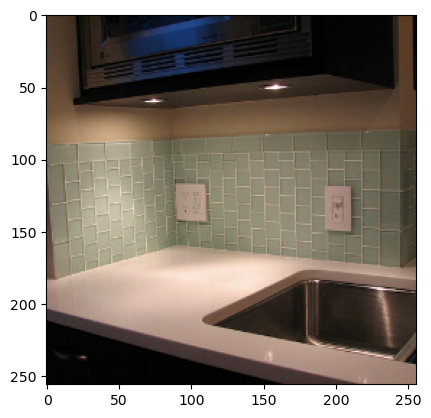

annotation ['Green tiled backsplash highlighted by low overhead lighting.', 'A kitchen counter is illuminated by a hood light', 'A kitchen sink next to an empty counter with a tiled wall.', 'A back splash is added to the wall in the kitchen.', 'A picture of a sink top with dim lighting.']
things ['appliance']


In [133]:
sample = next(iter(train_dl))
annotation = np.load(nsd_mindroot + '/subj%02d_annot.npy'%subj,allow_pickle=True)
things = np.load(nsd_mindroot + '/subj%02d_things.npy'%subj,allow_pickle=True)
for s in sample:
    print(s.shape)

voxels, images, coco, trial = sample
plt.imshow(images[0].permute(1,2,0))
plt.show()
print("annotation",annotation[trial[0]])
print("things",things[trial[0]])


In [134]:
def reconstruct_volume_corrected(vol_shape, binary_mask, data_vol, order='C'):
    """
    Reconstruct a 3D volume using a binary mask and flattened data volume.

    Parameters:
    - vol_shape: tuple of int, shape of the original 3D volume.
    - binary_mask: 1D array-like, flattened binary mask indicating the active voxels in the original volume.
    - data_vol: 1D array-like, flattened data values corresponding to the active voxels.
    - order: {'C', 'F'}, optional, default is 'C'. Specify the memory layout of the reconstructed volume.
             'C' means C-style (row-major), 'F' means Fortran-style (column-major).

    Returns:
    - 3D numpy array, the reconstructed volume.
    """
    view_vol = np.ones(np.prod(vol_shape), dtype=np.float32) * np.nan
    
    # Convert the binary mask to an index mask
    idx_mask = np.where(binary_mask)[0]
    
    view_vol[idx_mask] = data_vol
    return view_vol.reshape(vol_shape, order=order)
    
import nibabel as nib
# recover roi voxels back to original 3d shape
voxels = voxels[0,0].cpu().numpy()
nsdgeneral_roi_mask = nib.load('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz').get_fdata()==1
reconstructed = reconstruct_volume_corrected(nsdgeneral_roi_mask.shape, nsdgeneral_roi_mask.flatten(), voxels)
reconstructed = np.nan_to_num(reconstructed)

In [136]:
nsdgeneral_affine = nib.load('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz').affine

In [135]:
ori_mask = np.array(np.where(nsdgeneral_roi_mask==1)).T
recon_mask = np.array(np.where(reconstructed!=0)).T
for i in range(ori_mask.shape[0]):
    assert np.all(ori_mask[i]==recon_mask[i])

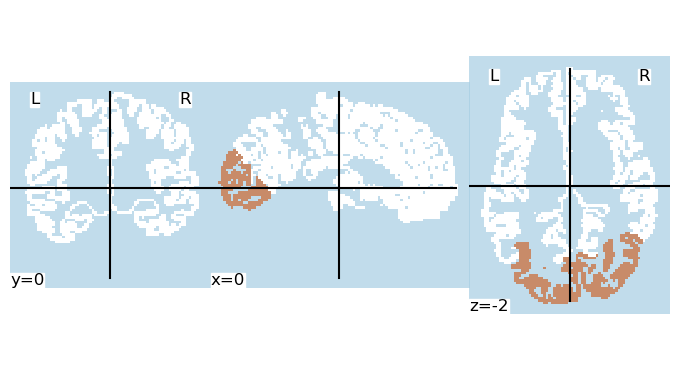

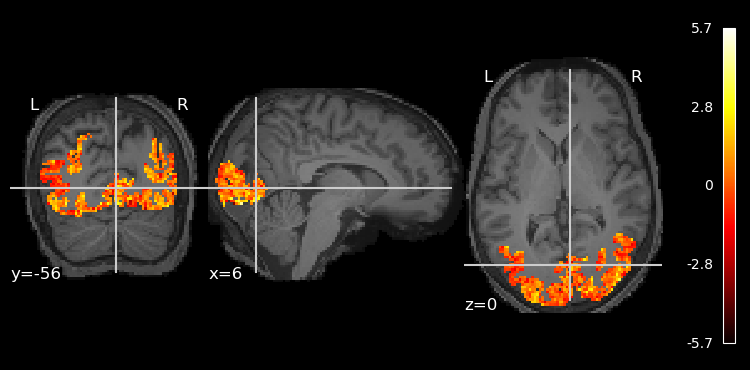

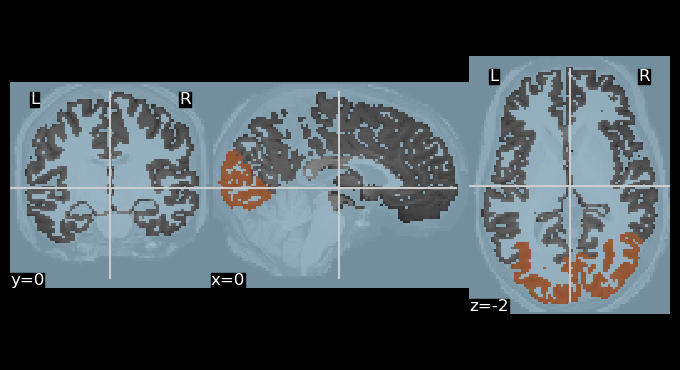

In [141]:
# plot mask
from nilearn import plotting
ni_img = nib.Nifti1Image(reconstructed,affine=nsdgeneral_affine)
nsdgeneral = '/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz'
anat_img = '/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/T1_to_func1pt8mm.nii.gz'
plotting.plot_roi(nsdgeneral,
                    bg_img=None,
                    cmap='Paired')
plotting.plot_stat_map(ni_img,
                    bg_img=anat_img,
                    cmap='hot')
plotting.plot_roi(nsdgeneral,
                    bg_img=anat_img,
                    cmap='Paired')